# Tutorial

This is a brief tutorial of basic Metagraph usage.

First, we import Metagraph:

In [1]:
import metagraph as mg

## Inspecting Types and Available Algorithms

The default resolver automatically pulls in all registered Metagraph plugins.

The default resolver also links itself with the `metagraph` namespace, allowing
users to ignore the default resolver in most cases.

In [2]:
res = mg.resolver

A hierarchy of available types is automatically added as properties on `res`.

In [3]:
dir(res.types)

['BipartiteGraph',
 'DataFrame',
 'EdgeMap',
 'EdgeSet',
 'Graph',
 'Matrix',
 'NodeMap',
 'NodeSet',
 'Vector']

Alternatively, simply access the types directly from `mg`.

Most attributes of `res` are exposed as attributes on `mg` for convenience.

In [4]:
dir(mg.types)

['BipartiteGraph',
 'DataFrame',
 'EdgeMap',
 'EdgeSet',
 'Graph',
 'Matrix',
 'NodeMap',
 'NodeSet',
 'Vector']

Two important concepts in Metagraph are abstract types and concrete types. 

Abstract types describe a generic kind of data container with potentially many equivalent representations.

Concrete types describe a specific data object which fits under the abstract type category.

One can think of abstract types as data container specifications and concrete types as implementations of those specifications.

For each abstract type, there are several concrete types.

Within a single abstract type, all concrete types are able to represent equivalent data, but in a different format or data structure.

Here we show the concrete types which represent `Graphs`:

In [5]:
dir(mg.types.Graph)

['GrblasGraphType', 'NetworkXGraphType', 'ScipyGraphType']

Available algorithms are listed under `mg.algos` and grouped by categories.

Note that these are also available under `res.algos`.

In [6]:
dir(mg.algos)

['bipartite',
 'centrality',
 'clustering',
 'embedding',
 'flow',
 'subgraph',
 'traversal',
 'util']

In [7]:
dir(mg.algos.traversal)

['all_pairs_shortest_paths',
 'astar_search',
 'bellman_ford',
 'bfs_iter',
 'bfs_tree',
 'dfs_iter',
 'dfs_tree',
 'dijkstra',
 'minimum_spanning_tree']

## Example Usage

Let's see how to use Metagraph by first constructing a graph from an edge list.

Begin with an input csv file representing an edge list and weights.

In [8]:
data = """
Source,Destination,Weight
0,1,4
0,3,2
0,4,7
1,3,3
1,4,5
2,4,5
2,5,2
2,6,8
3,4,1
4,7,4
5,6,4
5,7,6
"""

Read in the csv file and convert to a Pandas `DataFrame`.

In [9]:
import pandas as pd
import io
csv_file = io.StringIO(data)
df = pd.read_csv(csv_file)

This `DataFrame` represents a graph’s edges, but Metagraph doesn’t know that yet. To use the `DataFrame` within Metagraph, we first need to convert it into an `EdgeMap`.

A `PandasEdgeMap` takes a `DataFrame` plus the labels of the columns representing source, destination, and weight. With these, Metagraph will know how to interpret the `DataFrame` as an `EdgeMap`.

In [10]:
em = mg.wrappers.EdgeMap.PandasEdgeMap(df, 'Source', 'Destination', 'Weight', is_directed=False)
em.value

,Source,Destination,Weight
0,0,1,4
1,0,3,2
2,0,4,7
3,1,3,3
4,1,4,5
5,2,4,5
6,2,5,2
7,2,6,8
8,3,4,1
9,4,7,4


## Convert EdgeMap to a Graph

`Graphs` and `EdgeMaps` have many similarities, but `Graphs` are more powerful. `Graphs` can have weights on the nodes, not just on the edges. `Graphs` can also have isolate nodes (nodes with no edges), which `EdgeMaps` cannot have.

Most Metagraph algorithms take a `Graph` as input, so we will convert our `PandasEdgeMap` into a `Graph`. In this case, it will become a `NetworkXGraph`.

In [11]:
g = mg.algos.util.graph.build(em)
g

In [12]:
g.value.edges(data=True)

EdgeDataView([(0, 1, {'weight': 4}), (0, 3, {'weight': 2}), (0, 4, {'weight': 7}), (1, 3, {'weight': 3}), (1, 4, {'weight': 5}), (3, 4, {'weight': 1}), (4, 2, {'weight': 5}), (4, 7, {'weight': 4}), (2, 5, {'weight': 2}), (2, 6, {'weight': 8}), (5, 6, {'weight': 4}), (5, 7, {'weight': 6})])

## Translate to other Graph formats

Because Metagraph knows how to interpret `g` as a `Graph`, we can easily convert it other `Graph` formats.

Let's convert it to a `ScipyGraph`. This format stores the edges and weights in a scipy.sparse matrix along with a numpy array mapping the position to a NodeId (in case the nodes are not sequential from 0..n). Any node weights are stored in a separate numpy array.

In [13]:
g2 = mg.translate(g, mg.wrappers.Graph.ScipyGraph)
g2

The matrix is accessed using `g2.value`. The node list is accessed using `.node_list`.

We can verify the weighs and edges by inspecting the sparse adjacency matrix directly.

In [14]:
g2.value.toarray()

array([[0, 4, 0, 2, 7, 0, 0, 0],
       [4, 0, 0, 3, 5, 0, 0, 0],
       [0, 0, 0, 0, 5, 2, 8, 0],
       [2, 3, 0, 0, 1, 0, 0, 0],
       [7, 5, 5, 1, 0, 0, 0, 4],
       [0, 0, 2, 0, 0, 0, 4, 6],
       [0, 0, 8, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 4, 6, 0, 0]], dtype=int64)

We can also convert `g` into an adjacency matrix representation using a `GrblasGraph`. This also stores the edges and node weights separately.

In [15]:
g3 = mg.translate(g, mg.types.Graph.GrblasGraphType)
g3

In [16]:
g3.value

"M_0"          nvals  nrows  ncols  dtype
grblas.Matrix     24      8      8  INT64
-----------------------------------------
   0  1  2  3  4  5  6  7
0     4     2  7         
1  4        3  5         
2              5  2  8   
3  2  3        1         
4  7  5  5  1           4
5        2           4  6
6        8        4      
7              4  6

We can also visualize the graph.

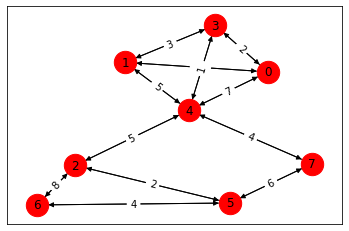

In [17]:
import grblas
grblas.io.draw(g3.value)

## Inspect the steps required for translations

Rather than actually converting `g` into other formats, let’s ask Metagraph how it will do the conversion. Each conversion requires a translator (written by plugin developers) to convert between the two formats. However, even if there isn’t a direct translator between two formats, Metagraph will find a path and take several translation steps as needed to perform the task.

The mechanism for viewing the plan is to invoke the translation from ``mg.plan.translate`` rather than ``mg.translate``. Other than the additional ``.plan``, the call signature is identical.

In this first example, there is a direct function which translates between `NetworkXGraphType` and `ScipyGraphType`.

In [18]:
mg.plan.translate(g, mg.types.Graph.ScipyGraphType)

[Direct Translation]
NetworkXGraphType -> ScipyGraphType

---
In this next example, there is no direct function which convert `NetworkXGraphType` into a `GrblasGraphType`. Instead, we have to first convert to `ScipyGraphType` and then to `GrblasGraphType` before finally arriving at our desired format.

While Metagraph will do the conversion automatically, understanding the steps involved helps users plan for expected computation time and memory usage. If needed, plugin developers can write a plugin to provide a direct translation path. 

In [19]:
mg.plan.translate(g, mg.types.Graph.GrblasGraphType)

[Multi-step Translation]
(start)  NetworkXGraphType
           -> ScipyGraphType
 (end)       -> GrblasGraphType

## Algorithm Example #1: Breadth First Search

Algorithms are described initially in an abstract definition. For bfs_iter, we take a `Graph` and return a `Vector` indicating the NodeIDs in the order visited.

After the abstract definition is written, multiple concrete implementations are written to operate on concrete types.

Let's look at the signature and specific implementations available for bfs_iter.

In [20]:
mg.algos.traversal.bfs_iter.signatures

Signature:
	(graph: Graph({}), source_node: NodeID, depth_limit: int = -1) -> Vector({})
Implementations:
	(graph: ScipyGraphType({}), source_node: NodeID, depth_limit: int = -1) -> NumpyVectorType({})
	(graph: NetworkXGraphType({}), source_node: NodeID, depth_limit: int = -1) -> NumpyVectorType({})


We see that there are two implementations available, each with a different type of input graph.

---
Let's perform a breadth-first search with our different representations of `g`. We should get approximately the same answer no matter which implementation is chosen (same NodeIDs within each depth level of the traversal).

In [21]:
cc = mg.algos.traversal.bfs_iter(g, 0)
cc

array([0, 1, 3, 4, 2, 7, 5, 6])

In [22]:
cc2 = mg.algos.traversal.bfs_iter(g2, 0)
cc2

array([0, 1, 3, 4, 2, 7, 5, 6])

---
Similar to how we can view the plan for translations, we can view the plan for algorithms.

No translation is needed because we already have a concrete implementation which takes a `NetworkXGraph` as input.

In [23]:
mg.plan.algos.traversal.bfs_iter(g, 0)

nx_breadth_first_search_iter
(graph: NetworkXGraphType({}), source_node: NodeID, depth_limit: int = -1) -> NumpyVectorType({})
Argument Translations
---------------------
** graph **
NetworkXGraphType
** source_node **
NodeID
** depth_limit **
int
---------------------

---
In the next example, `g2` also satisfies a concrete implementation, so no input translation is required.

In [24]:
mg.plan.algos.traversal.bfs_iter(g2, 0)

ss_breadth_first_search_iter
(graph: ScipyGraphType({}), source_node: NodeID, depth_limit: int = -1) -> NumpyVectorType({})
Argument Translations
---------------------
** graph **
ScipyGraphType
** source_node **
NodeID
** depth_limit **
int
---------------------

## Algorithm Example #2: Pagerank

Let's look at the same pieces of information, but for pagerank. Pagerank takes a `Graph` and returns a `NodeMap` indicating the rank value of each node in the graph.

First, let's verify the signature and the implementations available.

We see that there are two implementations available, taking a `NetworkXGraph` or `GrblasGraph` as input.

In [25]:
mg.algos.centrality.pagerank.signatures

Signature:
	(graph: Graph({'edge_type': 'map', 'edge_dtype': ('float', 'int')}), damping: float = 0.85, maxiter: int = 50, tolerance: float = 1e-05) -> NodeMap({})
Implementations:
	(graph: NetworkXGraphType({}), damping: float = 0.85, maxiter: int = 50, tolerance: float = 1e-05) -> PythonNodeMapType({})
	(graph: GrblasGraphType({}), damping: float = 0.85, maxiter: int = 50, tolerance: float = 1e-05) -> GrblasNodeMapType({})


---
Let's look at the steps required in the plan if we start with a `ScipyGraph`. Then let's perform the computation.

We see that the `ScipyGraph` will need to be translated to a `GrblasGraph` in order to call the algorithm. **Metagraph will do this for us automatically.**

In [26]:
mg.plan.algos.centrality.pagerank(g2)

grblas_pagerank
(graph: GrblasGraphType({}), damping: float = 0.85, maxiter: int = 50, tolerance: float = 1e-05) -> GrblasNodeMapType({})
Argument Translations
---------------------
** graph **  [Direct Translation]
ScipyGraphType -> GrblasGraphType
** damping **
float
** maxiter **
int
** tolerance **
float
---------------------

In [27]:
pr = mg.algos.centrality.pagerank(g2)
pr

The result is a `GrblasNodeMap` which can be inspected by looking at the underlying `.value`.

In [28]:
pr.value

"v_4"          nvals  size  dtype
grblas.Vector      8     8   FP64
---------------------------------
        0        1         2        3         4         5         6         7
  0.11991  0.11991  0.129191  0.11991  0.195384  0.133008  0.093041  0.089646

Let's translate it to a numpy array.

In [29]:
pr_array = mg.translate(pr, mg.types.NodeMap.NumpyNodeMapType)
pr_array.value

array([0.11990989, 0.11990989, 0.12919109, 0.11990989, 0.19538403,
       0.13300793, 0.09304149, 0.08964579])

**Helpful tip**: The translation type can also be specified as a string

In [30]:
mg.translate(pr, "NumpyNodeMap")

Now let's verify that we get the same answer with the NetworkX implementation of Pagerank. 
We can ensure the NetworkX implementation is called by passing in a NetworkXGraph. Because no translations
are required, it will choose that implementation.

The result is a `PythonNodeMapType`, which is simply a Python `dict`.

In [31]:
pr2 = mg.algos.centrality.pagerank(g)
pr2

{0: 0.11990989117844908,
 1: 0.11990989117844908,
 3: 0.11990989117844908,
 4: 0.1953840289789895,
 2: 0.12919108800740858,
 5: 0.13300793197881575,
 6: 0.09304148578762082,
 7: 0.08964579171181795}

Translate to a numpy array and verify the same results (within tolerance)

In [32]:
pr2_array = mg.translate(pr2, "NumpyNodeMap")
pr2_array.value

array([0.11990989, 0.11990989, 0.12919109, 0.11990989, 0.19538403,
       0.13300793, 0.09304149, 0.08964579])

In [33]:
abs(pr2_array - pr_array.value) < 1e-15

array([ True,  True,  True,  True,  True,  True,  True,  True])